In [1]:
import re

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymorphy2
import razdel


morph = pymorphy2.MorphAnalyzer()

In [2]:
train = pd.read_json('train.json')
train = train[train.text.str.len() < 10000]
train.shape

(7732, 3)

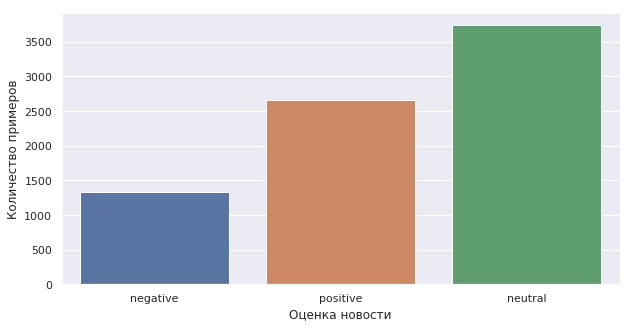

In [26]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="sentiment", data=train)
ax.set(xlabel='Оценка новости', ylabel='Количество примеров');

In [3]:
from multiprocessing import Pool
from tqdm import tqdm


def _foo(x):
    return ' '.join([
        morph.parse(token.text)[0].normal_form 
        for token in razdel.tokenize(re.sub(r'[^а-ё ]', ' ', x.lower()))
    ])


with Pool(8) as p:
    texts = list(tqdm(p.imap(_foo, train.text.values), total=len(train)))

100%|██████████| 7732/7732 [03:56<00:00, 41.18it/s]


In [4]:
train['text_prep'] = texts

In [3]:
train = pd.read_csv('train_prep.csv')

In [4]:
negative = train[train.sentiment == 'negative']
positive = train[train.sentiment == 'positive']
neutral = train[train.sentiment == 'neutral']

In [5]:
negative_freq = negative.text_prep.str.split(expand=True).stack().value_counts()
positive_freq = positive.text_prep.str.split(expand=True).stack().value_counts()
neutral_freq = neutral.text_prep.str.split(expand=True).stack().value_counts()

In [6]:
negative_set = set(negative_freq.index)
positive_set = set(positive_freq.index)
neutral_set = set(neutral_freq.index)

In [7]:
negative_words = set(negative_freq.index) - set(positive_freq.index)
positive_words = set(positive_freq.index) - set(negative_freq.index)
neutral_words = set(neutral_freq.index)

In [8]:
print('Плохие слова')
negative_freq[negative_freq.index.isin(negative_words)][:50]

Плохие слова


терентьев           113
акжаркын             83
нацбюро              70
экстраординарный     69
анарбай              59
галим                50
аймагамбет           50
саранский            45
джакуп               41
бахт                 40
лоббирование         38
санкционировать      35
сарий                33
дильрух              33
айтимбет             32
оштрафовать          30
керосин              29
взяточничество       29
твориться            27
дутбаев              27
махинация            26
болашакер            26
самоподжог           24
жанбосынов           24
невиновность         24
отбывание            24
арестованный         24
исправительный       23
халатность           23
выговор              22
подзащитный          21
санкционирование     21
тюремный             21
ффк                  21
категорически        20
вирус                20
поймать              20
вернал               20
возмущаться          20
перепечатка          19
чекист               19
никифоров       

In [9]:
print('Хорошие слова')
positive_freq[positive_freq.index.isin(positive_words)][:50]

Хорошие слова


делегация          156
физкульт           143
корабль            121
мельниченко        121
шёлковый           113
аутизм              80
упражнение          77
ассамблея           71
экспедиция          70
паромный            69
вэтс                65
универсал           65
стандартизация      59
казань              57
берлин              56
баскетбольный       56
курык               55
арабский            53
перевалка           52
выпускаться         52
ибраимов            49
агрохимический      49
коррекционный       48
взаимовыгодный      47
транскаспийский     47
ента                47
аутист              46
эмират              46
водородный          46
цинк                45
манюров             45
гюзель              44
ультразвуковой      44
тихоненко           44
машиностроитель     43
наставник           42
апк                 42
актогай             42
пирс                42
нак                 42
байконур            42
ярмарка             41
ссуда               41
вьетнам    

In [10]:
pos_freq = dict(positive_freq)
neg_freq = dict(negative_freq)
neu_freq = dict(neutral_freq)

In [12]:
def word_sentiment(word):
    #word = morph.parse(word.lower())[0].normal_form
    if word in negative_words:
        neg = neg_freq[word]
        
        if word in neutral_words:
            neu = neg_freq[word]
            
            if neg > neu/2:
                return -neg/2
            if neu > neg:
                return 0
            
        return -neg #-1
        
    if word in positive_words:
        pos = pos_freq[word]
        
        if word in neutral_words:
            neu = neu_freq[word]
            
            if pos > neu/2:
                return pos/2
            if neu > pos:
                return 0
            
        return pos #1
    
    return 0

In [13]:
from multiprocessing import Pool
from tqdm import tqdm


def _foo(x):
    return sum([word_sentiment(w) for w in x.split()])


with Pool(4) as p:
    pred = list(tqdm(p.imap(_foo, train.text_prep.values), total=len(train)))

100%|██████████| 7732/7732 [00:01<00:00, 6472.02it/s]


In [14]:
train['pred'] = pred

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
def threshold(x, pos_thres, neg_thres):
    if x > pos_thres:
        return 'positive'
    if x < neg_thres:
        return 'negative'
    return 'neutral'

#train['result'] = train.pred.apply(threshold)

In [19]:
from sklearn.metrics import f1_score

In [20]:
def score(x):
    pos_thres, neg_thres = x
    train['result'] = train.probs.apply(lambda x: threshold(x, pos_thres, neg_thres))
    return f1_score(train.sentiment, train.result, average='macro')

In [21]:
train['probs'] = train.apply(lambda x: x.pred / len(x.text_prep.split()), axis=1)

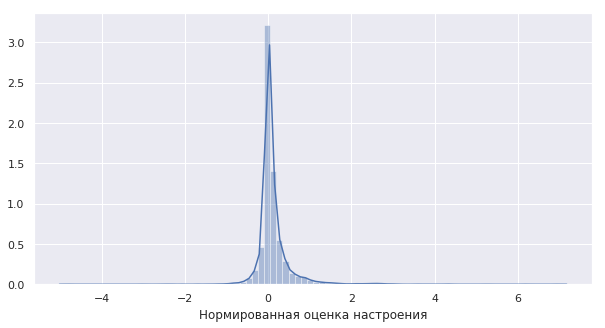

In [23]:
plt.figure(figsize=(10, 5))

ax = sns.distplot(train.probs.values, bins=80)#.set_title('Распределение настроения новостей');
ax.set(xlabel='Нормированная оценка настроения');#№, ylabel='Количество примеров');

In [290]:
from scipy.optimize import minimize

In [291]:
res = minimize(score, [0,-0], method='BFGS', options={'xtol': 1e-8, 'disp': True})

/home/e1four15f/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: OptimizeWarning: Unknown solver options: xtol
  """Entry point for launching an IPython kernel.
/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py

/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Optimization terminated successfully.
         Current function value: 0.412189
         Iterations: 1
         Function evaluations: 44
         Gradient evaluations: 11


/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/e1four15f/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [292]:
res

      fun: 0.4121893760065604
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 44
      nit: 1
     njev: 11
   status: 0
  success: True
        x: array([0.00000000e+00, 5.12589879e-05])

In [38]:
score([0.1, -0.05])

0.6853966392399009

In [35]:
from sklearn.metrics import classification_report

In [40]:
print(classification_report(train.sentiment.values, train.result.values))

              precision    recall  f1-score   support

    negative       0.73      0.68      0.71      1337
     neutral       0.66      0.72      0.69      3734
    positive       0.70      0.63      0.66      2661

    accuracy                           0.68      7732
   macro avg       0.70      0.68      0.69      7732
weighted avg       0.68      0.68      0.68      7732



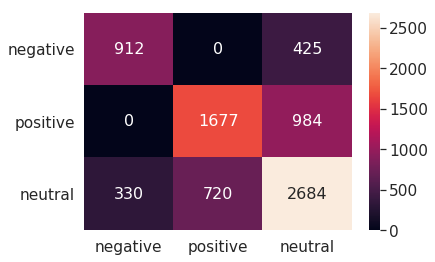

In [39]:
labels = train.sentiment.unique()
array = confusion_matrix(train.sentiment, train.result, labels)
df_cm = pd.DataFrame(array, labels, labels)
                  
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.5g');
plt.yticks(rotation=0);

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion

In [42]:
clf = Pipeline([
    ('tfidf', FeatureUnion([
        ('word', TfidfVectorizer(ngram_range=(1, 2), max_features=20000)),
        ('char', TfidfVectorizer(analyzer='char', ngram_range=(3, 5), max_features=10000))
    ])),
    ('clf', LogisticRegression(n_jobs=4, solver='lbfgs', multi_class='auto')),
])
clf = clf.fit(train.text.values, train.sentiment.values)

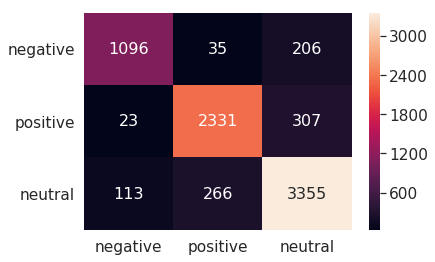

In [333]:
labels = train.sentiment.unique()
array = confusion_matrix(train.sentiment, clf.predict(train.text.values), labels)
df_cm = pd.DataFrame(array, labels, labels)
                  
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.5g');
plt.yticks(rotation=0);

In [43]:
pred = clf.predict(train.text.values)

In [45]:
print(classification_report(train.sentiment.values, pred))

              precision    recall  f1-score   support

    negative       0.89      0.82      0.85      1337
     neutral       0.87      0.90      0.88      3734
    positive       0.89      0.88      0.88      2661

    accuracy                           0.88      7732
   macro avg       0.88      0.86      0.87      7732
weighted avg       0.88      0.88      0.88      7732

